# Scaling with Combinators and the Static Modeling Language

Up until this point, we have been using [Gen's generic built-in modeling language](https://www.gen.dev/dev/ref/modeling/), which is a very flexible modeling language that is shallowly embedded in Julia. However, better performance and scaling characteristics can be obtained using specialized modeling languages or modeling constructs. This notebook introduces two built-in features of Gen:

- A more specialized [Static Modeling Language](https://www.gen.dev/dev/ref/modeling/#Static-Modeling-Language-1) which is built-in to Gen.

- A class of modeling constructs called [Generative function combinators](https://www.gen.dev/dev/ref/combinators/).

These features provide both constant-factor speedups, as well as improvements in asymptotic orders of growth, over the generic built-in modeling language.


## Outline

**Section 1**: [Studying the scaling behavior of an inference algorithm](#scaling)

**Section 2**: [Introducing the map combinator](#map)

**Section 3**: [Combining the map combinator with the static modeling language](#combining)

**Section 4**: [Constant-factor performance gains from the static modeling language](#constant)

**Section 5**: [Checking the inference programs](#checking)

In [1]:
using Gen

## 1. Studying the scaling behavior of an inference program <a name="studying"></a>

Recall the robust regression model used to introduce iterative inference in [an earlier tutorial](Iterative%20Inference%20In%20Gen.ipynb):

In [2]:
@gen function model(xs::Vector{Float64})
    slope ~ normal(0, 2)
    intercept ~ normal(0, 2)
    noise ~ gamma(1, 1)
    prob_outlier ~ uniform(0, 1)
    
    n = length(xs)
    ys = Vector{Float64}(undef, n)
    
    for i = 1:n
        if ({:data => i => :is_outlier} ~ bernoulli(prob_outlier))
            (mu, std) = (0., 10.)
        else
            (mu, std) = (xs[i] * slope + intercept, noise)
        end
        ys[i] = {:data => i => :y} ~ normal(mu, std)
    end
    ys
end;

We wrote a Markov chain Monte Carlo inference update for this model that performs updates on each of the 'global' parameters (noise, slope, intercept, and prob_outlier), as well as the 'local' `is_outlier` variable associated with each data point. The update takes a trace as input, and returns the new trace as output. We reproduce this here:

In [3]:
function block_resimulation_update(tr)
    
    # Block 1: Update the line's parameters
    line_params = select(:noise, :slope, :intercept)
    (tr, _) = mh(tr, line_params)
    
    # Blocks 2-N+1: Update the outlier classifications
    (xs,) = get_args(tr)
    n = length(xs)
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end
    
    # Block N+2: Update the prob_outlier parameter
    (tr, _) = mh(tr, select(:prob_outlier))
    
    # Return the updated trace
    tr
end;

We write a helper function that takes a vector of y-coordinates and populates a constraints choice map:

In [4]:
function make_constraints(ys::Vector{Float64})
    constraints = choicemap()
    for i=1:length(ys)
        constraints[:data => i => :y] = ys[i]
    end
    constraints
end;

Finally, we package this into an inference program that takes the data set of all x- and y-coordinates ,and returns a trace. We will be experimenting with different variants of the model, so we make the model an argument to this function:

In [5]:
function block_resimulation_inference(model, xs, ys)
    observations = make_constraints(ys)
    (tr, _) = generate(model, (xs,), observations)
    for iter=1:500
        tr = block_resimulation_update(tr)
    end
    tr
end;

Let's see how the running time of this inference program changes as we increase the number of data points. We don't expect the running time to depend too much on the actual values of the data points, so we just construct a random data set for each run:

In [ ]:
ns = [1, 3, 7, 10, 30, 70, 100, 125]
times = []
for n in ns
    xs = rand(n)
    ys = rand(n)
    start = time_ns()
    tr = block_resimulation_inference(model, xs, ys)
    push!(times, (time_ns() - start) / 1e9)
end

We now plot the running time versus the number of data points:

In [7]:
using Plots

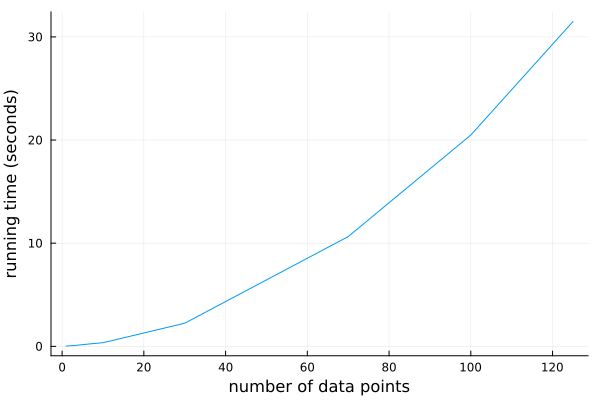

In [ ]:
plot(ns, times, xlabel="number of data points", ylabel="running time (seconds)", label=nothing)

The inference program seems to scale quadratically in the number of data points.

To understand why, consider the block of code inside `block_resimulation_update` that loops over the data points:

```julia
# Blocks 2-N+1: Update the outlier classifications
(xs,) = get_args(tr)
n = length(xs)
for i=1:n
    (tr, _) = mh(tr, select(:data => i => :is_outlier))
end
```

The reason for the quadratic scaling is that the running time of the call to `mh` inside this loop also grows in proportion to the number of data points. This is because the updates to a trace of a model written the generic built-in modeling language always involve re-running **the entire** model generative function.

However, it should be possible for the algorithm to scale linearly in the number of data points. Briefly, deciding whether to update a given `is_outlier` variable can be done without referencing the other data points. This is because each `is_outiler` variable is conditionally independent of the outlier variables and y-coordinates of the other data points, conditioned on the parameters.

We can make this conditional independence structure explicit using the [Map generative function combinator](https://probcomp.github.io/Gen/dev/ref/combinators/#Map-combinator-1). Combinators like map encapsulate common modeling patterns (e.g., a loop in which each iteration is making independent choices), and when you use them, Gen can take advantage of the restrictions they enforce to implement performance optimizations automatically during inference. The `Map` combinator, like the `map` function in a functional programming language, helps to execute the same generative code repeatedly. 

## 2. Introducing the map combinator <a name="map"></a>

To use the map combinator to express the conditional independences in our model, we first write a generative function to generate the `is_outlier` variable and the y-coordinate for a single data point:

In [9]:
@gen function generate_single_point(x::Float64, prob_outlier::Float64, noise::Float64,
                                    slope::Float64, intercept::Float64)
    is_outlier ~ bernoulli(prob_outlier)
    mu  = is_outlier ? 0. : x * slope + intercept
    std = is_outlier ? 10. : noise
    y ~ normal(mu, std)
    return y
end;

We then apply the [`Map`](https://probcomp.github.io/Gen/dev/ref/combinators/#Map-combinator-1), which is a Julia function, to this generative function, to obtain a new generative function:

In [10]:
generate_all_points = Map(generate_single_point);

This new generative function has one argument for each argument of `generate_single_point`, except that these arguments are now vector-valued instead of scalar-valued. We can run the generative function on some fake data to test this:

In [11]:
xs = Float64[0, 1, 2, 3, 4]
prob_outliers = fill(0.5, 5)
noises = fill(0.2, 5)
slopes = fill(0.7, 5)
intercepts = fill(-2.0, 5)
trace = simulate(generate_all_points, (xs, prob_outliers, noises, slopes, intercepts));

We see that the `generate_all_points` function has traced 5 calls to `generate_single_point`, under namespaces `1` through `5`.  The `Map` combinator automatically adds these indices to the trace address.

In [12]:
get_choices(trace)

│
├── 1
│   │
│   ├── :y : -2.072263757817142
│   │
│   └── :is_outlier : false
│
├── 2
│   │
│   ├── :y : -1.2422118452900144
│   │
│   └── :is_outlier : false
│
├── 3
│   │
│   ├── :y : -0.7980078415047424
│   │
│   └── :is_outlier : false
│
├── 4
│   │
│   ├── :y : -0.2052289686925668
│   │
│   └── :is_outlier : false
│
└── 5
    │
    ├── :y : 0.8943808045320579
    │
    └── :is_outlier : false


Now, let's replace the Julia `for` loop in our model with a call to this new function:

In [13]:
@gen function model_with_map(xs::Vector{Float64})
    slope ~ normal(0, 2)
    intercept ~ normal(0, 2)
    noise ~ gamma(1, 1)
    prob_outlier ~ uniform(0, 1)
    n = length(xs)
    data ~ generate_all_points(xs, fill(prob_outlier, n), fill(noise, n), fill(slope, n), fill(intercept, n))
    return data
end;

Note that this new model has the same address structure as our original model had, so our inference code will not need to change. For example, the 5th data point's $y$ coordinate will be stored at the address `:data => 5 => :y`, just as before. (The `:data` comes from our `data ~ ...` invocation in the `better_model` definition, and the `:y` comes from `generate_point`; only the `5` has been inserted automatically by `Map`.)

In [14]:
trace = simulate(model_with_map, (xs,));
get_choices(trace)

│
├── :intercept : 0.6926466046821981
│
├── :slope : 3.105910949464447
│
├── :prob_outlier : 0.465164045437206
│
├── :noise : 0.05271896140398963
│
└── :data
    │
    ├── 1
    │   │
    │   ├── :y : -0.21877768527867045
    │   │
    │   └── :is_outlier : true
    │
    ├── 2
    │   │
    │   ├── :y : 1.6122599657817949
    │   │
    │   └── :is_outlier : true
    │
    ├── 3
    │   │
    │   ├── :y : 6.88220843827699
    │   │
    │   └── :is_outlier : false
    │
    ├── 4
    │   │
    │   ├── :y : -17.831260217372527
    │   │
    │   └── :is_outlier : true
    │
    └── 5
        │
        ├── :y : 12.990361632786698
        │
        └── :is_outlier : false


Let's test the running time of the inference program, applied to this new model:

In [15]:
with_map_times = []
for n in ns
    xs = rand(n)
    ys = rand(n)
    start = time_ns()
    tr = block_resimulation_inference(model_with_map, xs, ys)
    push!(with_map_times, (time_ns() - start) / 1e9)
end

We plot the results and compare them to the original model, which used the Julia `for` loop:

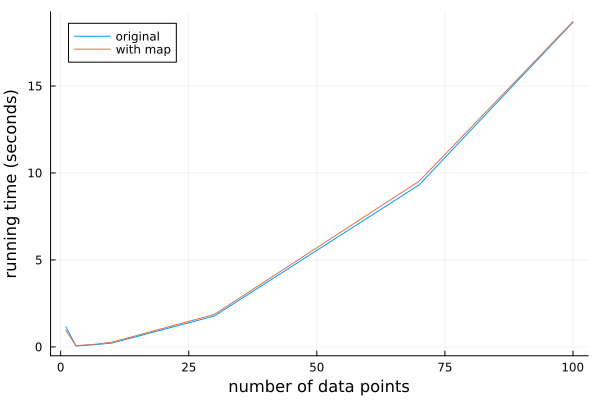

In [16]:
plot(ns, times, label="original", xlabel="number of data points", ylabel="running time (seconds)")
plot!(ns, with_map_times, label="with map")

We see that the quadratic scaling did not improve. In fact, we actually got a that happed was a constant factor **slowdown**.

We can understand why we still have quadratic scaling, by examining the call to `generate_single_point`:

```julia
data ~ generate_all_points(xs, fill(prob_outlier, n), fill(noise, n), fill(slope, n), fill(intercept, n))
```

Even though the function `generate_all_points` knows that each of the calls to `generate_single_point` is conditionally independent, and even it knows that each update to `is_outlier` only involves a single application of `generate_single_point`, it does not know that **none of its arguments change** within an update to `is_outlier`. Therefore, it needs to visit each call to `generate_single_point`. The generic built-in modeling language does not provide this information the generative functions that it invokes.

## 3.Combining the map combinator with the static modeling language <a name="combining"></a>

In order to provide `generate_all_points` with the knowledge that its arguments do not change during an update to the `is_outlier` variable, we need to write the top-level model generative function that calls `generate_all_points` in the [Static Modeling Language](https://probcomp.github.io/Gen/dev/ref/modeling/#Static-Modeling-Language-1), which is a restricted variant of the built-in modeling language that uses static analysis of the computation graph to generate specialized trace data structures and specialized implementations of trace operations. We indicate that a function is to be interpreted using the static language using the `static` annotation:

In [17]:
@gen (static) function static_model_with_map(xs::Vector{Float64})
    slope ~ normal(0, 2)
    intercept ~ normal(0, 2)
    noise ~ gamma(1, 1)
    prob_outlier ~ uniform(0, 1)
    n = length(xs)
    data ~ generate_all_points(xs, fill(prob_outlier, n), fill(noise, n), fill(slope, n), fill(intercept, n))
    return data
end;

The static language has a number of restrictions that make it more amenable to static analysis than the unrestricted modeling language. For example, we cannot use Julia `for` loops, and the return value needs to explicitly use the `return` keyword, followed by a symbol (e.g. `data`). Also, each symbol used on the left-hand side of an assignment must be unique. A more complete list of restrictions is given in the documentation.

Below, we show the static dependency graph that Gen builds for this function. Arguments are shown as diamonds, Julia computations are shown as squares, random choices are shown as circles, and calls to other generative function are shown as stars. The call that produces the return value of the function is shaded in blue.

<img src="graph.png" width="100%"/>

Now, consider the update to the `is_outlier` variable:
```julia
(tr, _) = mh(tr, select(:data => i => :is_outlier))
```

Because this update only causes values under address `:data` to change, the `static_model_with_map` function can use the graph above to infer that none of the arguments to `generate_all_point` could have possibly changed. This will allow us to obtain the linear scaling we expected.

However, before we can use a function written in the static modeling language, we need to run the following function (this is required for technical reasons, because functions written in the static modeling language use a staged programming feature of Julia called *generated functions*).

In [18]:
Gen.@load_generated_functions

Finally, we can re-run the experiment with our model that combines the map combinator with the static language:

In [19]:
static_with_map_times = []
for n in ns
    xs = rand(n)
    ys = rand(n)
    start = time_ns()
    tr = block_resimulation_inference(static_model_with_map, xs, ys)
    push!(static_with_map_times, (time_ns() - start) / 1e9)
end

We compare the results to the results for the earlier models:

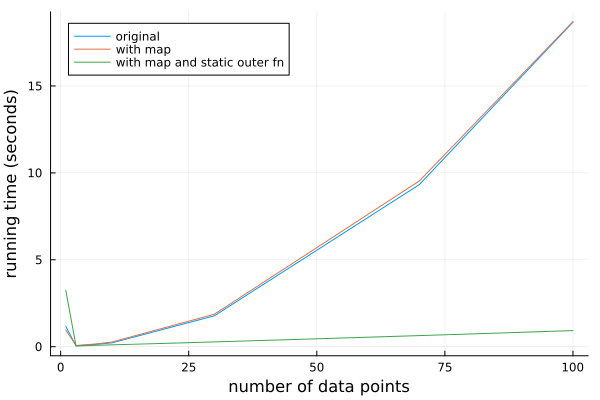

In [20]:
plot(ns, times, label="original", xlabel="number of data points", ylabel="running time (seconds)")
plot!(ns, with_map_times, label="with map")
plot!(ns, static_with_map_times, label="with map and static outer fn")

We see that we now have the linear running time that we expected.

## 4. Constant-factor performance gains from the static modeling language <a name="constant"></a>

**Note:** *the following section was drafted using an earlier version of Julia. As of Julia 1.7, the dynamic modeling language is fast enough in some cases that you may not see constant-factor performance gains by switching simple dynamic models, with few choices and no control flow, to use the static modeling language. Based on the experiment below, this model falls into that category.*

Note that in our latest model above, `generate_single_point` was still written in the dynamic modeling language. It is not necessary to write `generate_single_point` in the static language, but doing so might provide modest constant-factor performance improvements. Here we rewrite this function in the static language. The static modeling language does not support `if` statements, but does support ternary expressions (`a ? b : c`):

In [21]:
@gen (static) function static_generate_single_point(x::Float64, prob_outlier::Float64, noise::Float64,
                                    slope::Float64, intercept::Float64)
    is_outlier ~ bernoulli(prob_outlier)
    mu = is_outlier ? 0. : x * slope + intercept
    std = is_outlier ? 10. : noise
    y ~ normal(mu, std)
    return y
end;

In [22]:
static_generate_all_points = Map(static_generate_single_point);

In [23]:
@gen (static) function fully_static_model_with_map(xs::Vector{Float64})
    slope ~ normal(0, 2)
    intercept ~ normal(0, 2)
    noise ~ gamma(1, 1)
    prob_outlier ~ uniform(0, 1)
    n = length(xs)
    data ~ static_generate_all_points(xs, fill(prob_outlier, n), fill(noise, n), fill(slope, n), fill(intercept, n))
    return data
end;

In [24]:
Gen.@load_generated_functions

Now, we re-run the experiment with our new model:

In [25]:
fully_static_with_map_times = []
for n in ns
    xs = rand(n)
    ys = rand(n)
    start = time_ns()
    tr = block_resimulation_inference(fully_static_model_with_map, xs, ys)
    push!(fully_static_with_map_times, (time_ns() - start) / 1e9)
end

In earlier versions of Julia, we saw a modest improvement in running time, but here (running Julia 1.7.1) we see it makes little to no difference:

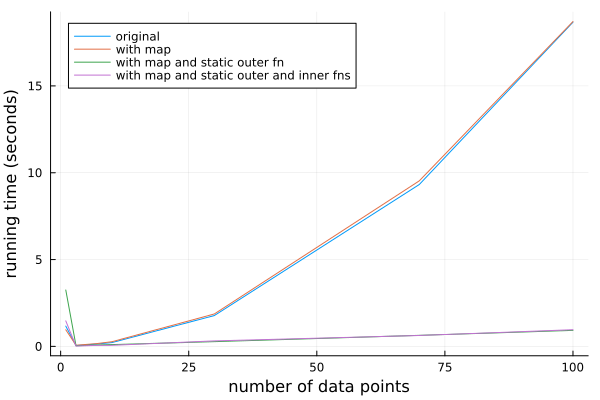

In [26]:
plot(ns, times, label="original", xlabel="number of data points", ylabel="running time (seconds)")
plot!(ns, with_map_times, label="with map")
plot!(ns, static_with_map_times, label="with map and static outer fn")
plot!(ns, fully_static_with_map_times, label="with map and static outer and inner fns")

## 5. Checking the inference programs <a name="checking"></a>

Before wrapping up, let's confirm that all of our models are giving good results:

Let's use a synthetic data set:

In [27]:
true_inlier_noise = 0.5
true_outlier_noise = 10.
prob_outlier = 0.1
true_slope = -1
true_intercept = 2
xs = collect(range(-5, stop=5, length=50))
ys = Float64[]
for (i, x) in enumerate(xs)
    if rand() < prob_outlier
        y = 0. + randn() * true_outlier_noise
    else
        y = true_slope * x + true_intercept + randn() * true_inlier_noise 
    end
    push!(ys, y)
end
ys[end-3] = 14
ys[end-5] = 13;

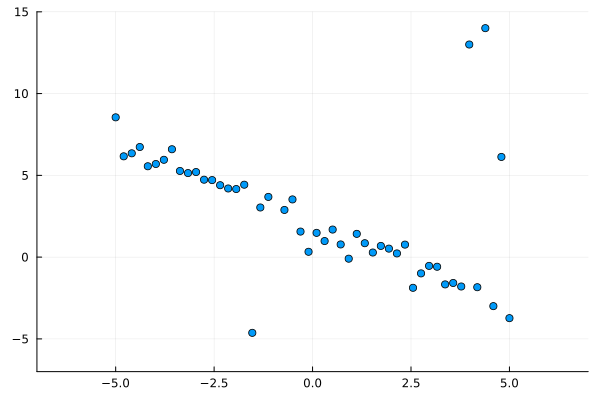

In [28]:
scatter(xs, ys, xlim=(-7,7), ylim=(-7,15), label=nothing)

We write a trace rendering function that shows the inferred line on top of the observed data set:

In [29]:
function render_trace(trace, title)
    xs,  = get_args(trace)
    xlim = [-5, 5]
    slope = trace[:slope]
    intercept = trace[:intercept]
    plot(xlim, slope * xlim .+ intercept, color="black", xlim=(-7,7), ylim=(-7,15), title=title, label=nothing)
    ys = [trace[:data => i => :y] for i=1:length(xs)]
    scatter!(xs, ys, label=nothing)
end;

Finally, we run the experiment. We will visualize just one trace produced by applying our inference program to each of the four variants of our model:

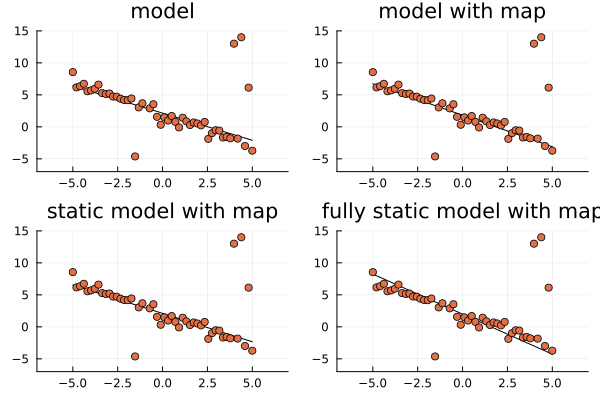

In [30]:
tr = block_resimulation_inference(model, xs, ys)
fig1 = render_trace(tr, "model")

tr = block_resimulation_inference(model_with_map, xs, ys)
fig2 = render_trace(tr, "model with map")

tr = block_resimulation_inference(static_model_with_map, xs, ys)
fig3 = render_trace(tr, "static model with map")

tr = block_resimulation_inference(fully_static_model_with_map, xs, ys)
fig4 = render_trace(tr, "fully static model with map")

plot(fig1, fig2, fig3, fig4)

It looks like inference in all the models seems to be working reasonably.